# Clasificación de Estados

Recordemos algunas de las formas de cómo podemos clasificar los estados en una cadena de Markov con sus definiciones intuitivas:

- **Absorbente**: un estado que, una vez alcanzado, no se abandona.
- **Transitorio**: un estado que, con probabilidad 1, se abandona para siempre eventualmente.
- **Recurrente**: un estado que se visitará infinitas veces con probabilidad 1.
- **Periódico**: un estado al que solo se puede regresar en múltiplos de un número mayor que 1.


Veamos cómo podemos identificar a cada uno de este tipo de estados en una matriz de transición.

Supongamos que tenemos una cadena de Markov con la siguiente matriz de transición:

\begin{bmatrix}
1 & 0 & 0 & 0 \\
0.3 & 0.4 & 0.3 & 0 \\
0 & 0 & 1 & 0 \\
0.1 & 0.3 & 0 & 0.6
\end{bmatrix}

¿qué estados son absorbentes?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Matriz de transición
P_absorbente = np.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.3, 0.4, 0.3, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.1, 0.3, 0.0, 0.6],
])

estados = [0, 1, 2, 3]

# Verificamos estados absorbentes: P[i, i] == 1
absorbentes = [i for i in range(len(P_absorbente)) if P_absorbente[i, i] == 1]
print("Estados absorbentes:", [estados[i] for i in absorbentes])


Estados absorbentes: [0, 2]


Veamos cómo cambian las probabilidades en una cadena de Markov de periodo 2, dada por la matriz de transición

\begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}

**Idea para simular la evolución de las distribuciones**

1. Definimos $\pi_0$, la distribución inicial. Se puede generar aleatoriamente o darla.

2. Definimos $\pi_1$ haciendo:

$$ \pi_1 = \pi_0 P$$

$\quad$ donde $P$ es la matriz de transición.

3. De manera recursirva, hacemos:

$$ \pi_k = \pi_{k-1} P$$
$\quad$ para cada $k \geq 1$

Podemos guardar las distribuciones e ir viendo su evolución en el tiempo por medio de histogramas o gráficos de líneas.


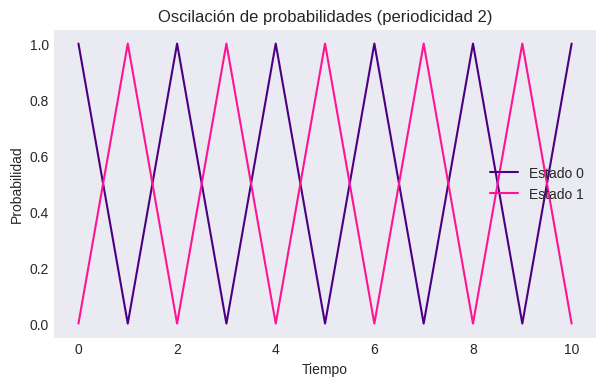

In [ ]:
# Definimos la matriz
P_periodica = np.array([
    [0.0, 1.0],
    [1.0, 0.0],
])

# Definimos una distribución inicial y vamos guardando cada distribución
dist = np.array([1.0, 0.0])  # Distribución inicial \pi_0
hist = [dist]  # Hacemos una lista de distribuciones

# Iteramos las 10 primeras distribuciones
for _ in range(10):
    dist = dist @ P_periodica
    hist.append(dist)

# Graficamos ambas distribuciones
hist = np.array(hist)
plt.figure(figsize=(7,4))
plt.style.use('seaborn-v0_8-dark')
plt.plot(hist[:, 0], label="Estado 0", color = 'indigo')
plt.plot(hist[:, 1], label="Estado 1", color = 'deeppink')
plt.title("Oscilación de probabilidades (periodicidad 2)")
plt.xlabel("Tiempo")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()


### Tiempo medio de retorno

#### **Idea para simular el tiempo medio de retorno**

Si $y \in \mathcal{S}$ es un estado, se define $m_y = \mathbb{E}_y(T_y < \infty)$, que es el tiempo medio de retorno. Como esto es una esperanza, podemos usar el método de Monte Carlo para calcularla.

**Método de Monte Carlo**

Recordemos la Ley Fuerte de los Grandes Números:

Si $\{X_n\}_{n \in \mathbb{N}}$ es una sucesión de variables aleatorias i.i.d con $\mu = \mathbb{E}(X_1) < \infty$, entonces:

$$ \displaystyle \lim_{n \to \infty} \frac{\sum_{i=0}^nX_i}{n} = \mu$$

Entonces si quiero calcular la esperanza de una variable aleatoria $X$, simulo una muestra de $n$ elementos de ésta y calculo su media muestral para $n >> 1$.

**Observación Importante**: En este caso, la variable de la cual queremos la esperanza es $T_y$ depende de la trayectoria del proceso, entonces tendremos que simular $n$ trayectorias del proceso y para cada una calcular $T_y$.

**Ejemplo**

Consideremos la cadena de Markov con matriz de transición:

\begin{pmatrix}
0 & 0.5 & 0.5 \\
0.25 & 0.5 & 0.25 \\
0.25 & 0.25 & 0.5
\end{pmatrix}

Podemos notar que la cadena es irreducible, entonces trataremos de calcular $m_y$ para cada uno de los estados. Usaremos nuestro código de cadena de Markov del notebook pasado y añadiremos una función para calcular el tiempo medio de retorno de un estado.

In [ ]:
class CadenaMarkov:

  # Definimos el constructor de la clase
  def __init__(self, P, pi_0):
    self.P = P
    self.pi_0 = pi_0
    self.estados = list(range(len(pi_0))) # Nuevo: Definimos el espacio de estados
    self.proceso = [np.random.choice(range(len(pi_0)), p = pi_0)]

  # Simulamos la cadena igual que antes
  def simular(self, iter):
    for i in range(iter):
      estado_actual = self.proceso[-1]
      xn = np.random.choice(range(len(self.pi_0)), p = self.P[estado_actual])
      self.proceso.append(int(xn))
    return self.proceso

  # Graficamos la trayectoria generada de nuestro proceso
  def plot(self, co):
    plt.figure(figsize=(7,4))
    plt.plot(self.proceso, '-', color = co, ms=1)
    plt.style.use('seaborn-v0_8-dark')
    plt.grid()
    plt.title('Cadena de Markov')
    plt.xlabel('Iteración')
    plt.ylabel('Estado')
    plt.show()

  # Función para calcular m_y, recibe iteraciones de cada trayectoria y número de trayectorias
  def Tiempos_retorno(self, y, iter, trayectorias):
    # Verificamos que el estado esté en el conjunto de estados
    if not y in self.estados:
      return None
    else:
      muestra = []
      # Generamos tantas trayectorias como indiquemos
      for _ in range(trayectorias):
        # Generamos una trayectoria que empiece en el estado que queremos
        cadena_y = CadenaMarkov(self.P, [1 if i == y else 0 for i in range(len(self.pi_0))])
        # Simulamos la trayectoria
        cadena_y.simular(iter)
        # Verificamos el tiempo de retorno de esa trayectoria y lo añadimos a la lista muestra
        for t in range(1, len(cadena_y.proceso)):
          if cadena_y.proceso[t] == y:
            muestra.append(t)
            break
      # Si todo sale bien, devolvemos la media muestral de la muestra de T_y
      if muestra:
        return sum(muestra) / len(muestra)
      else:
        return None

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

P1 = np.array([[0, 0.5, 0.5],
               [0.25, 0.5, 0.25],
               [.25, 0.25, 0.5]])

cadena_prueba = CadenaMarkov(P1, [1,0,0])
print('El tiempo medio de retorno a 0 es:', cadena_prueba.Tiempos_retorno(0, 1000, 1000), '\n a 1 es:', cadena_prueba.Tiempos_retorno(1, 1000, 1000),
      '\n a 2 es:', cadena_prueba.Tiempos_retorno(2, 1000, 1000))

El tiempo medio de retorno a 0 es: 5.086 
 a 1 es: 2.466 
 a 2 es: 2.413


Esta es una buena forma de estimar el tiempo medio de recurrencia de cada estado en una Cadena de Markov.

**Ejercicio**

Calcula el tiempo medio de recurrencia de cada estado de la cadena de Markov con matriz de transición:

\begin{bmatrix}
0.25 & 0.25 & 0.25 & 0.25 \\
0.4 & 0.3 & 0.2 & 0.1 \\
0.05 & 0 & 0.95 & 0 \\
0.2 & 0.3 & 0.1 & 0.6
\end{bmatrix}

Describe la cadena y clasifica los estados.